In [1]:
import pandas as pd
import numpy as np
import collections
import datetime
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegressionCV
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay 
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import learning_curve

In [ ]:
Helper Functions: plot_lift()

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv(r"HIS_combined_821.csv",index_col = 0).reset_index(drop=True)

In [4]:
# create a unique patint_uid
df['patient_uid']=df['关联键'].astype(str)+"_"+df['证件号（id）'].astype(str)

# remove rows that meet some condition, in this case removing depts specified as below
pt_to_remove = df[df['科室'].isin(["儿科",'正畸科','儿科特诊','三叶儿童齿科','儿科一','儿科二'])]['patient_uid']
df_leftjoined=df.merge(pt_to_remove, on='patient_uid', how='left', indicator=True)

df_removed = df_leftjoined[~(df_leftjoined['_merge']=='both')].drop(['关联键', '证件号（id）', '_merge'], axis=1)
# verify results
print(df_removed.shape)
df_removed.head()

(129561, 12)


,性别,年龄,诊断代码,诊断名称,治疗计划,消费项目,项目金额（实付）,消费时间,收费分类,科室,初复诊,patient_uid
42,女,17,K05.100,慢性龈炎,洁治+SPT,口腔常规检查,5.00,1/1/2018 10:08:18.835,治疗费,洁牙美白中心,复,5344955.0_33010620000327****
43,女,17,K05.100,慢性龈炎,洁治+SPT,洁治(包括超声洁治),112.00,1/1/2018 10:08:18.837,治疗费,洁牙美白中心,复,5344955.0_33010620000327****
44,女,17,K05.100,慢性龈炎,洁治+SPT,喷砂去色素.,134.40,1/1/2018 10:08:18.839,治疗费,洁牙美白中心,复,5344955.0_33010620000327****
45,女,17,K05.100,慢性龈炎,洁治+SPT,防龋抗敏抛光术,89.60,1/1/2018 10:08:18.841,治疗费,洁牙美白中心,复,5344955.0_33010620000327****
397,男,57,"K05.300,K04.902,K04.902","慢性牙周炎,牙周牙髓综合征,牙周牙髓综合征",16截根术、17.15.14翻瓣术试留16.17\n17若出现牙髓症状酌情RCT或拔除,阿替卡因肾上腺素注射液,16.96,1/2/2018 10:39:13.239,西药费,牙周科,复,2626876.0_33010319600619****


In [5]:
idx_to_remove = df_removed[df_removed['消费项目'].str.contains('口腔常规检查', regex=False)].reset_index()['index']
#idx_to_remove.head()
#print(idx_to_remove.shape, len(o))
df_leftjoined2=df_removed.reset_index().merge(idx_to_remove, on='index', how='left', indicator=True)
#df_leftjoined2.head()
df_removed2 = df_leftjoined2[~(df_leftjoined2['_merge']=='both')].drop('_merge', axis=1)
df_removed2.shape

(112758, 13)

In [6]:
idx_to_remove = df_removed[df_removed['收费分类'].str.contains('种植费', regex=False) & df_removed['消费项目'].str.contains('手术一次性材料费（手术时收）', regex=False)]\
                         .reset_index()['index']
df_leftjoined3=df_removed2.merge(idx_to_remove, on='index', how='left', indicator=True)

df_removed3 = df_leftjoined3[~(df_leftjoined3['_merge']=='both')].drop('_merge', axis=1)
df_removed3.shape

(112315, 13)

## 2. processing positive and negative patient dataframe
### 2.1 positive dataset

In [7]:
# series of patient_uid with implant billing 
pt_uid_implant = df_removed3[df_removed3['收费分类']=="种植费"]['patient_uid'].drop_duplicates()

# create subset of df pt_implant_all for patient_uid with implant billing 
pt_implant_all=df_removed3.merge(pt_uid_implant, on='patient_uid', how='inner')

pt_implant_all['date']=pd.to_datetime(pt_implant_all['消费时间']).dt.date
pt_implant_all = pt_implant_all.fillna('Unknown')

print(df_removed3.shape, pt_implant_all.shape)#,  pat_implant1.shape)
pt_implant_all.head()

(112315, 13) (24444, 14)


,index,性别,年龄,诊断代码,诊断名称,治疗计划,消费项目,项目金额（实付）,消费时间,收费分类,科室,初复诊,patient_uid,date
0,429,男,60,K04.000,牙髓炎,Unknown,进口氧化锆全瓷冠一级.,5415.0,1/3/2018 12:02:30.804,修复费,名医馆,复,2790315.0_33010519570308****,2018-01-03
1,430,男,60,K04.000,牙髓炎,Unknown,全瓷树脂粘结(HS),114.0,1/3/2018 12:02:30.806,修复费,名医馆,复,2790315.0_33010519570308****,2018-01-03
2,431,男,60,K04.000,牙髓炎,Unknown,树脂临时牙制作费 (HS),57.0,1/3/2018 12:02:30.807,修复费,名医馆,复,2790315.0_33010519570308****,2018-01-03
3,432,男,60,K04.000,牙髓炎,Unknown,硅橡胶取模（双层）(HS),85.5,1/3/2018 12:02:30.809,修复费,名医馆,复,2790315.0_33010519570308****,2018-01-03
4,433,男,60,K04.000,牙髓炎,Unknown,纤维树脂桩核（单根）(HS),665.0,1/3/2018 12:02:30.81,修复费,名医馆,复,2790315.0_33010519570308****,2018-01-03


In [8]:
# from the implant df subset, select the earliest date with implant billing for every patient as the implant date
pt_implant_all.sort_values(by=['patient_uid', 'date'], ascending=True, inplace=True)
pt_implant_date = pt_implant_all[pt_implant_all['收费分类']=="种植费"][['patient_uid', 'date']]\
                                .groupby('patient_uid').agg(implant_date=('date', min))


# create a column 'implant date' and 'ayearbfore_implant_date' for every patient 
pt_implant_all1=pt_implant_all.set_index('patient_uid')
for pt in pt_uid_implant:
    pt_implant_all1.loc[pt, 'implant_date']=pt_implant_date.loc[pt, 'implant_date']
    
pt_implant_all1['a_year_bfore_implant_date'] = pt_implant_all1['implant_date']-datetime.timedelta(days= 365) 


# filter pt records within specified time window, 
# that is, dates within a year prior to the implant date and implant date is at least a year before the start date 2018/01/01 
pt_implant_all2 = pt_implant_all1[(pt_implant_all1['date'] < pt_implant_all1['implant_date'])\
                & (pt_implant_all1['date'] >= pt_implant_all1['a_year_bfore_implant_date'])\
                & (pt_implant_all1['a_year_bfore_implant_date'] >= pd.to_datetime('2018-01-01 00:00')) ].drop('index', axis=1)

print(pt_implant_all1.shape, pt_implant_date, pt_implant_all2.shape)
pt_implant_all2.head()

(24444, 15)                                implant_date
patient_uid                                
1.01084e+17_33012519760122****   2019-07-05
1.0144e+17_33068119980327****    2019-01-18
1.01746e+17_33252219850510****   2018-03-18
1.03929e+17_33072272072****      2018-04-10
1.10516e+17_33032519580927****   2019-02-27
...                                     ...
9.0861e+16_33012419630629****    2018-03-30
9.3849e+16_32062119851123****    2020-04-28
9.55936e+16_33010452102****      2019-03-12
9.56524e+16_33012519631128****   2019-08-27
9.59726e+16_33062519451002****   2018-07-24

[603 rows x 1 columns] (5309, 14)


,性别,年龄,诊断代码,诊断名称,治疗计划,消费项目,项目金额（实付）,消费时间,收费分类,科室,初复诊,date,implant_date,a_year_bfore_implant_date
patient_uid,,,,,,,,,,,,,,
1.01084e+17_33012519760122****,女,43,K04.000,牙髓炎,45牙RCT后桩+冠修复,盐酸甲哌卡因肾上腺素注射液,9.82,6/22/2019 13:12:57.614,西药费,特需专家二,复,2019-06-22,2019-07-05,2018-07-05
1.01084e+17_33012519760122****,女,43,K04.000,牙髓炎,45牙RCT后桩+冠修复,牙髓失活术,15.00,6/22/2019 13:13:06.091,治疗费,特需专家二,复,2019-06-22,2019-07-05,2018-07-05
1.01084e+17_33012519760122****,女,43,K04.000,牙髓炎,45牙RCT后桩+冠修复,失活剂（HS）,15.00,6/22/2019 13:13:06.093,治疗费,特需专家二,复,2019-06-22,2019-07-05,2018-07-05
1.01084e+17_33012519760122****,女,43,K04.000,牙髓炎,45牙RCT后桩+冠修复,简单充填术(包括I、V类洞的充填),30.00,6/22/2019 13:13:06.095,治疗费,特需专家二,复,2019-06-22,2019-07-05,2018-07-05
1.01084e+17_33012519760122****,女,43,K04.000,牙髓炎,45牙RCT后桩+冠修复,局部浸润麻醉,10.00,6/22/2019 13:13:06.097,手术费,特需专家二,复,2019-06-22,2019-07-05,2018-07-05


In [9]:
print('unique pt: before time window "{}", after "{}"\n------------------------'.format(pt_uid_implant.shape[0], len(pt_implant_all2.index.unique())))

unique pt: before time window "603", after "320"
------------------------


In [10]:
def create_feature_df(df, groupby_field='patient_uid'):

    f1 = df.groupby('patient_uid').agg(diagnosis=('诊断名称', 'unique'))
    f2 = df.groupby('patient_uid').agg(treatment_plan=('治疗计划', 'unique'))
    f3 = df.groupby('patient_uid').agg(purchase=('消费项目', 'unique'))
    f4 = df.groupby('patient_uid').agg(total_order=('项目金额（实付）', 'sum'))
    f5 = df.groupby('patient_uid').agg(dept=('科室', 'unique'))
    f6 = df.groupby('patient_uid').agg(gender=('性别', 'unique'))
    f7 = df.groupby('patient_uid').agg(age=('年龄', 'max'))
    f8 = df.groupby('patient_uid').agg(dxcode=('诊断代码', 'unique'))
    f9 = df.groupby('patient_uid').agg(order_type=('收费分类', 'unique'))

    f10 = df.groupby(['patient_uid', 'date']).agg(order_by_visit=('项目金额（实付）', 'sum'))\
                        .groupby('patient_uid').agg(mean_order=('order_by_visit', 'mean'))

    f11 = df.groupby('patient_uid').agg(date_list=('date', 'unique'))
    f11['duration_days'] = f11['date_list'].map(lambda x: (x.max()-x.min()).days)
    
    f12 = df.groupby('patient_uid').agg(visits=('date', 'nunique'))
    
    
    f_list = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12]
    linked_df = reduce(lambda x, y: x.merge(y, on='patient_uid', how='inner'), f_list)
    linked_df['visit_interval']=linked_df['duration_days']/linked_df['visits']
    return linked_df

linked_implant_df = create_feature_df(pt_implant_all2)
linked_implant_df.head()

,diagnosis,treatment_plan,purchase,total_order,dept,gender,age,dxcode,order_type,mean_order,date_list,duration_days,visits,visit_interval
patient_uid,,,,,,,,,,,,,,
1.01084e+17_33012519760122****,[牙髓炎],"[45牙RCT后桩+冠修复, Unknown]","[盐酸甲哌卡因肾上腺素注射液, 牙髓失活术, 失活剂（HS）, 简单充填术(包括I、V类洞的...",862.04,[特需专家二],[女],43,[K04.000],"[西药费, 治疗费, 手术费, 放射费, 材料费]",431.020,"[2019-06-22, 2019-07-02]",10,2,5.00
1.0144e+17_33068119980327****,"[牙齿缺少, 牙体缺损, 慢性龈炎, 根管治疗后疾病]","[Unknown, 洁治+SPT。]","[数字化成像（DR), 阿替卡因肾上腺素注射液, 硅橡胶取模（双层）(HS), 全瓷树脂粘结...",5952.63,"[特需专家二, 洁牙美白中心]",[男],20,"[K00.002, K07.303, K05.100, K04.100.]","[放射费, 西药费, 修复费, 手术费, 治疗费]",1190.526,"[2018-05-25, 2018-06-01, 2018-06-13, 2018-06-2...",124,5,24.80
1.10516e+17_33032519580927****,"[慢性根尖周炎, 牙髓炎, 牙隐裂,牙髓炎]","[建议16RCT术, Unknown, 今拟拔除16牙，告知患者拔牙风险，排除拔牙禁忌症。]","[阿替卡因肾上腺素注射液, 局部浸润麻醉, 简单充填术(包括I、V类洞的充填), 开髓引流术...",1989.90,[特需专家一],[女],60,"[K04.500, K04.000, K04.000..,K04.000]","[西药费, 手术费, 治疗费, 放射费, 材料费]",497.475,"[2018-10-13, 2018-10-21, 2018-11-04, 2018-11-12]",30,4,7.50
1.15872e+17_33012519500923****,"[牙列部分缺失,残留牙根,慢性牙周炎, 慢性牙周炎]",[1、上半口：拔除13、21、22，种植13、23，覆盖义齿修复上半口缺失牙\n2、方案1：...,"[阿替卡因肾上腺素注射液, 局部浸润麻醉, 前牙拔除术, 义齿裂纹及折裂修理(HS), 锥形...",550.48,[名医馆],[女],69,"[K08.104,K08.301,K05.300, K05.300]","[西药费, 手术费, 修复费, 放射费]",275.240,"[2019-12-05, 2019-12-19]",14,2,7.00
1.38003e+17_33010619750409****,[慢性牙周炎],"[Unknown, 36建议拔除]","[牙周探诊检查, 神经阻滞麻醉（不能用于开髓、前牙、前磨牙拔除）, 磨牙拔除术, 进口止血膏...",678.12,"[牙周科, 特需专家二]",[女],43,[K05.300],"[治疗费, 手术费, 材料费, 西药费, 放射费]",169.530,"[2018-11-06, 2018-11-14, 2018-11-29, 2019-03-07]",121,4,30.25


### 2.2. Negative dataset

In [11]:
df_removed4 = df_removed3.merge(pt_uid_implant, on='patient_uid', how='left', indicator=True)

pt_noimplant_all = df_removed4[df_removed4['_merge']=='left_only'].drop('_merge', axis=1)

pt_noimplant_all['date']=pd.to_datetime(pt_noimplant_all['消费时间']).dt.date
pt_noimplant_all = pt_noimplant_all.fillna('Unknown')

pt_noimplant_all_1=pt_noimplant_all.set_index('patient_uid')
pt_uid_noimplant = pt_noimplant_all_1.index.unique()

In [12]:
# from the noimplant pt subset, select the latest date for every patient, apply a time windeow to filter records within a year from the latest date
pt_noimplant_lastest_date = pt_noimplant_all.groupby('patient_uid').agg(latest_date=('date', 'max'))

# create a column 'implant date' and 'ayearbfore_implant_date' for every patient 
for pt in pt_uid_noimplant:
    pt_noimplant_all_1.loc[pt, 'latest_date']=pt_noimplant_lastest_date.loc[pt, 'latest_date']
    
pt_noimplant_all_1['a_year_bfore_latest_date'] = pt_noimplant_all_1['latest_date']-datetime.timedelta(days= 365) 
# pt_noimplant_all_1.head()

pt_noimplant_all_2=pt_noimplant_all_1[ (pt_noimplant_all_1['date'] > pt_noimplant_all_1['a_year_bfore_latest_date'])\
                   & (pt_noimplant_all_1['date'] < pt_noimplant_all_1['latest_date'])
                   & (pt_noimplant_all_1['a_year_bfore_latest_date'] > pd.to_datetime('2018-01-01 00:00')) ].drop('index', axis=1).drop_duplicates()

#print(pt_noimplant_all_1.shape, pt_noimplant_lastest_date, pt_noimplant_all_2.shape)
#print(pre_noimplant.shape, pt_noimplant_all_2.shape)

In [13]:
linked_noimplant_df = create_feature_df(pt_noimplant_all_2)
linked_noimplant_df.head()

,diagnosis,treatment_plan,purchase,total_order,dept,gender,age,dxcode,order_type,mean_order,date_list,duration_days,visits,visit_interval
patient_uid,,,,,,,,,,,,,,
1.01813e+17_33010619971115****,[牙科检查],[Unknown],[充填体抛光术(HS)],8.00,[特需专家一],[女],21,[Z01.200],[治疗费],8.000000,[2019-08-31],0,1,0.000000
1.01824e+17_33018419901128****,[阻生齿],[Unknown],"[阻生牙拔除术（含牙龈翻瓣）, 局部麻醉（自费时用）, 数字化成像（DR), 阿替卡因肾上腺...",142.98,[名医馆],[男],28,[K01.100],"[手术费, 放射费, 西药费]",142.980000,[2019-10-02],0,1,0.000000
1.02175e+17_33010219680103****,"[牙髓炎, 慢性根尖周炎]","[Unknown, 15继续根管治疗。]","[牙髓失活术, 失活剂（HS）, 简单充填术(包括I、V类洞的充填), 局部浸润麻醉, 盐酸...",1203.82,[名医馆],[女],51,"[K04.000, K04.500]","[治疗费, 手术费, 西药费, 放射费, 材料费]",300.955000,"[2019-06-30, 2019-08-17, 2019-08-30, 2019-10-20]",112,4,28.000000
1.02754e+17_33038119930913****,"[颞下颌关节疾患, 中龋,深龋]",[告知右侧髁突情况，建议结合CBCT影像判断髁突吸收情况，如存在髁突吸收，建议先行合板治疗稳...,"[锥形束CT口腔成像, 软頜垫(HS), 超声纳米树脂充填（HS）, 纳米树脂充填(HS)]",8360.00,"[颌面外科, 特需专家一]",[女],25,"[K07.600, K02.900..,K02.900…]","[放射费, 修复费, 治疗费]",2786.666667,"[2019-03-31, 2019-05-12, 2019-05-16]",46,3,15.333333
1.02819e+17_32088119791212****,"[龋齿,慢性牙周炎]",[1.48.42建拔\n2.牙周基础治疗+SPT],"[洁治(包括超声洁治), 防龋抗敏抛光术, 口腔局部冲洗上药(不能用于根管冲洗.）, 牙周常...",211.00,[牙周科],[男],39,"[K02.900,K05.300]",[治疗费],211.000000,[2019-08-20],0,1,0.000000


In [14]:
print('Dataframe of implant patient from YH {}'.format(linked_implant_df.shape))#, link_implant.shape))
print('Dataframe of non-implant patient from YH {}'.format(linked_noimplant_df.shape))#, link_noimplant.shape))

Dataframe of implant patient from YH (320, 14)
Dataframe of non-implant patient from YH (3360, 14)


In [15]:
linked_noimplant_df['implant']=0
linked_implant_df['implant']=1

linked_all = linked_noimplant_df.append(linked_implant_df)
linked_all.shape

(3680, 15)

## 3. EDA, Data Cleaning, Built Features

In [16]:
linked_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 1.01813e+17_33010619971115**** to 9.55936e+16_33010452102****
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   diagnosis       3680 non-null   object 
 1   treatment_plan  3680 non-null   object 
 2   purchase        3680 non-null   object 
 3   total_order     3680 non-null   float64
 4   dept            3680 non-null   object 
 5   gender          3680 non-null   object 
 6   age             3680 non-null   int64  
 7   dxcode          3680 non-null   object 
 8   order_type      3680 non-null   object 
 9   mean_order      3680 non-null   float64
 10  date_list       3680 non-null   object 
 11  duration_days   3680 non-null   int64  
 12  visits          3680 non-null   int64  
 13  visit_interval  3680 non-null   float64
 14  implant         3680 non-null   int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 460.0+ KB


In [17]:
linked_all[linked_all['implant']==1].describe()
linked_all[linked_all['implant']==0].describe()

,total_order,age,mean_order,duration_days,visits,visit_interval,implant
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.0
mean,4642.832969,47.990625,1233.161469,68.350000,2.840625,18.473263,1.0
std,10070.693716,14.128494,1928.176417,96.348551,1.992833,27.753877,0.0
min,8.480000,19.000000,8.480000,0.000000,1.000000,0.000000,1.0
25%,419.620000,36.000000,273.365000,0.000000,1.000000,0.000000,1.0
50%,1373.220000,47.500000,637.185952,17.000000,2.000000,7.000000,1.0
75%,4553.422500,60.000000,1483.447500,102.250000,4.000000,29.361111,1.0
max,112766.200000,82.000000,16109.457143,349.000000,10.000000,164.000000,1.0


,total_order,age,mean_order,duration_days,visits,visit_interval,implant
count,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.0
mean,2777.573006,36.925893,1071.435317,46.927679,2.290179,14.714369,0.0
std,5274.157544,14.028408,1681.922389,84.052794,1.719205,28.723532,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
25%,491.537500,27.000000,311.537500,0.000000,1.000000,0.000000,0.0
50%,1217.700000,34.000000,673.800000,7.000000,2.000000,3.500000,0.0
75%,2952.820000,44.000000,1292.055000,41.000000,3.000000,11.500000,0.0
max,187669.820000,91.000000,62556.606667,356.000000,19.000000,176.500000,0.0


In [18]:
# plt.boxplot([linked_all[linked_all['implant']==1]['total_order'], linked_all[linked_all['implant']==0]['total_order']]);

# ax = linked_all[linked_all['implant']==0]['total_order'].plot.hist(density=True)

def plt_compare_hist(df, label, col_name, bins=50, density=True):
    
    _, bins, _ = plt.hist(df[df[label]==0][col_name], bins=bins, density=density, label='negative')#, normed=True)
    _ = plt.hist(linked_all[linked_all[label]==1][col_name], bins=bins, alpha=0.5, density=True, label='positive')#, normed=True)
    plt.legend(loc='upper right')
    plt.show();
    return

def create_compare_violin(df, col_name, label='implant'):
    sns.violinplot(data=df, x=label, y=col_name, hue=label, palette="muted", split=True)
    return

### 3.1. EDA, remove outlier in "total_order"

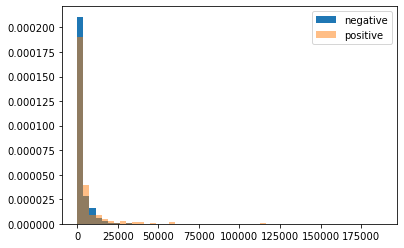

In [19]:
plt_compare_hist(linked_all, 'implant', 'total_order')

(3680, 15) (3672, 15)


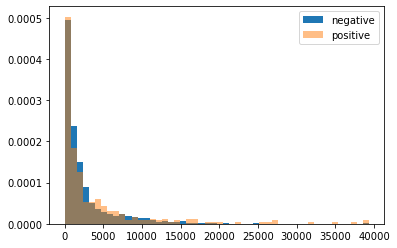

In [20]:
#linked_all[(linked_all['implant']==0) & (linked_all['total_order']>50000)].head()
#linked_all[(linked_all['implant']==1) & (linked_all['total_order']>50000)].head()
linked_all1=linked_all[~(linked_all['total_order']>40000)]
print(linked_all.shape, linked_all1.shape)
plt_compare_hist(linked_all1, 'implant', 'total_order')

### 3.2. EDA of mean_order

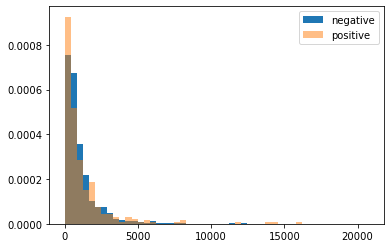

In [21]:
plt_compare_hist(linked_all1, 'implant', 'mean_order')

### 3.3. EDA, Cleaning of "age"

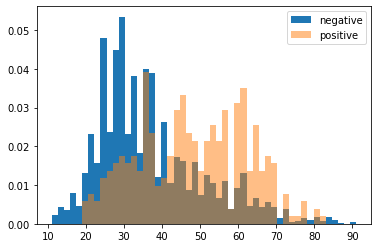

In [22]:
linked_all2=linked_all1[~(linked_all1['age']<10)]
plt_compare_hist(linked_all2, 'implant', 'age')

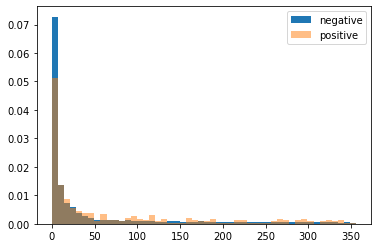

In [23]:
plt_compare_hist(linked_all2, 'implant', 'duration_days')

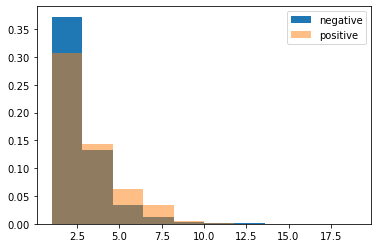

In [24]:
plt_compare_hist(linked_all2, 'implant', 'visits', 10)

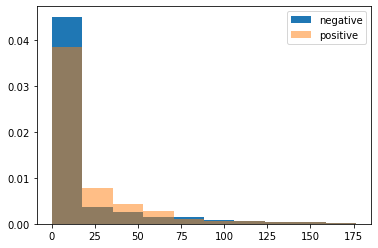

In [25]:
plt_compare_hist(linked_all2, 'implant', 'visit_interval', 10)

### 3.4. Cleaning, Contingency Table for "gender"

In [26]:
# Remove pt with mulitple gender
linked_all3 = linked_all2[~(linked_all2['gender'].map(lambda x: len(x)) > 1)].copy()

linked_all3.loc[:, 'gender'] = linked_all3.loc[:,'gender'].map(lambda x: x[0]).map({'女': 0, '男': 1})
linked_all3['gender']

patient_uid
1.01813e+17_33010619971115****    0
1.01824e+17_33018419901128****    1
1.02175e+17_33010219680103****    0
1.02754e+17_33038119930913****    0
1.02819e+17_32088119791212****    1
                                 ..
8.10964e+16_33032719550303****    1
8.11042e+16_33038219920724****    0
9.01935e+16_33012519741112****    0
9.3849e+16_32062119851123****     1
9.55936e+16_33010452102****       1
Name: gender, Length: 3653, dtype: int64

In [27]:
#temp = linked_all3.reset_index().groupby(['implant', 'gender']).agg(cnt=('patient_uid', 'count'))

crosstab = linked_all3.reset_index().pivot_table(index='gender', columns='implant', values='patient_uid', aggfunc='count', margins=True)
crosstab
crosstab1=crosstab.copy()
crosstab1.loc[:,0:1]=crosstab1.loc[:,0:1].div(crosstab1['All'], axis=0)
crosstab1

implant,0,1,All
gender,,,
0,1943,150,2093
1,1395,165,1560
All,3338,315,3653


implant,0,1,All
gender,,,
0,0.928333,0.071667,2093
1,0.894231,0.105769,1560
All,0.913770,0.086230,3653


### 3.5. Cleaning of "diagnosis" and creating a patient diagnosis sparse matrix, truncate low frequency diagnosis < 10

In [28]:
def cleaned_text(d: list):
    return [o for o in re.sub(r'[^\u4e00-\u9fff]', ' ', str(d)).split(" ") if (o != "") & (len(o) > 0) ]

def cleaned_code(d: list):
    return [x for x in  re.findall(r'[a-zA-Z]\d{2}.\d{3}', str(d))]

def create_pt_categorical_feature_matrix(df0, col, truncated_n=0):
    
    df=df0.copy()
    # clean text in col
    l = []
    for d in df[col]:    
        l += cleaned_text(d)
    
    # create a corpus of categorical features from col
    bag_of_cat_feature = set(l)
    
    df.loc[:, col] = df.loc[:, col].map(cleaned_text)
    
    # create a dict of {feature: count of feature}
    cnt_feature=dict()
    for d in bag_of_cat_feature:
        v = 0
        for m in l:
            if m==d:
                v+=1
        cnt_feature[d]=v
    
    if truncated_n>0:
        cnt_feature_sorted = {k: v for k,v in sorted(cnt_feature.items(), key=lambda item: item[1], reverse=True) if v>truncated_n}
    else:
        cnt_feature_sorted = {k: v for k,v in sorted(cnt_feature.items(), key=lambda item: item[1], reverse=True)}
    
    # iterate on pt_uid and col to create  {pt_uid: one-hot coding of categorical feature dict}
    bag_of_featuer_sorted = set([k for k in cnt_feature_sorted.keys()])
    
    # create a {patient_uid: feature coding dict}
    pt_feature_dict=dict()  
    for pt in df.index:
        pt_feature=df.loc[pt, col]

        # Iterating bag_of_featuer_sorted, if feature in "col" = 1, else = 0 
        feature_matrix = dict()
        for d in list(bag_of_featuer_sorted):
            if d in pt_feature:
                feature_matrix[d]=1
            else:
                feature_matrix[d]=0

        pt_feature_dict[pt]=feature_matrix
    
    # create a pt_uid, categorical feature dataframe and rename columns
    df_pt_feature = pd.DataFrame.from_dict(pt_feature_dict, orient='index')
    
    cols_feature_dict = {v: col+str(i) for i, v in enumerate(cnt_feature_sorted)}

    df_pt_feature.rename(columns=cols_feature_dict, inplace=True)
    
    return df_pt_feature, cols_feature_dict, cnt_feature_sorted


def create_pt_vector(df0, col, vector_type, truncated_n, is_dxcode=False):
    
    df=df0.copy()
    # clean text in col
    l = []
    
    if is_dxcode:
        for d in df[col]:    
            l += cleaned_code(d)
        bag_of_cat_feature = set(l)
        df.loc[:, col] = df.loc[:, col].map(cleaned_code).astype(str)
    
    else:
        for d in df[col]:    
            l += cleaned_text(d)
    # create a corpus of categorical features from col
        bag_of_cat_feature = set(l)
        df.loc[:, col] = df.loc[:, col].map(cleaned_text).astype(str)
    
    
    if vector_type == 'tf':
        # using count-Vector 
        if is_dxcode:
            token_pattern_dxcode=r'[a-zA-Z]\d{2}.\d{3}'
            vectorizer = CountVectorizer(min_df=truncated_n, token_pattern=token_pattern_dxcode)
        else:
            vectorizer = CountVectorizer(min_df=truncated_n)  
        X = vectorizer.fit_transform(df[col])
        bag_of_features = vectorizer.get_feature_names() 
        count_of_features = X.toarray().sum(axis=0)
        
        # using tf-idf vectorizer 
    elif vector_type =='tfidf':
        if is_dxcode:
            token_pattern_dxcode=r'[a-zA-Z]\d{2}.\d{3}'
            vectorizer = TfidfVectorizer(min_df=truncated_n, token_pattern=token_pattern_dxcode)
        else:
            vectorizer = TfidfVectorizer(min_df=truncated_n)
            
        X = vectorizer.fit_transform(df[col])
        bag_of_features = vectorizer.get_feature_names() 
        count_of_features = vectorizer.idf_
        
    cnt_feature = dict(zip(bag_of_features, count_of_features))
    feature_vector_sorted = {k: v for k,v in sorted(cnt_feature.items(), key=lambda item: item[1], reverse=True)}

    cols_feature_map = {v: col+str(i) for i, v in enumerate(feature_vector_sorted)}
    feature_cols_map = {v:k for k, v in cols_feature_map.items() }
    df1 = pd.DataFrame(X.toarray(), columns=bag_of_features, index=df0.index)

    out_df = df1.rename(columns=cols_feature_map)
        
    return out_df, feature_vector_sorted, feature_cols_map


### 3.6. Create a "dx" feature matrix

In [29]:
df_pt_dx, dx_vector_dict, dx_col_map= create_pt_vector(linked_all3, 'diagnosis', 'tfidf', 10)
len(dx_vector_dict)

45

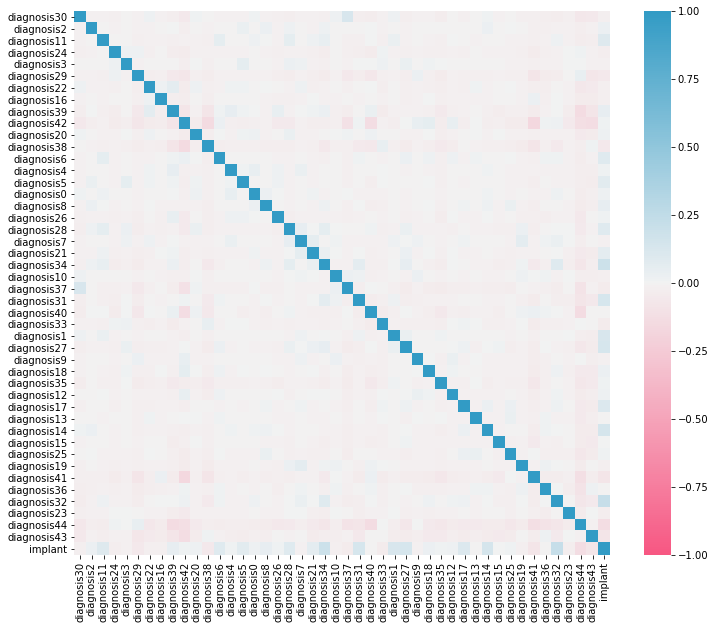

In [30]:
df_pt_dx['implant']=linked_all3['implant']
corr = df_pt_dx.corr()

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmax=1.0, vmin=-1.0, cmap=cmap)
plt.show();

In [31]:
drop_diagnosis = corr[corr['implant'].abs()<0.005].index
{d:dx_col_map[d] for d in drop_diagnosis}

{'diagnosis40': '牙体缺损', 'diagnosis15': '牙科检查'}

In [32]:
implant_pt_dx = df_pt_dx[df_pt_dx['implant']==1].sum().drop('implant').to_dict()
temp_implant = pd.DataFrame().from_dict(implant_pt_dx, orient='index', columns=['implant_pt_cnt']).sort_values(by=['implant_pt_cnt'], ascending=False)
temp_implant.head(10)

noimplant_pt_dx = df_pt_dx[df_pt_dx['implant']==0].sum().to_dict()
temp_noimplant = pd.DataFrame.from_dict(noimplant_pt_dx, orient='index', columns=['noimplant_pt_cnt']).sort_values(by=['noimplant_pt_cnt'], ascending=False)
temp_noimplant.head(10)

,implant_pt_cnt
diagnosis42,54.305367
diagnosis34,44.362824
diagnosis39,37.551484
diagnosis32,36.464658
diagnosis40,27.633514
diagnosis31,27.592598
diagnosis43,25.613032
diagnosis41,22.042009
diagnosis27,21.635254
diagnosis35,18.602540


,noimplant_pt_cnt
diagnosis44,626.053315
diagnosis42,526.091284
diagnosis43,514.375156
diagnosis41,490.998836
diagnosis40,296.267867
diagnosis38,283.627269
diagnosis39,259.978215
diagnosis37,232.631306
diagnosis35,165.472926
diagnosis36,154.554683


In [33]:
def pca_feature_reduction(df, cols, pca_alias, label_col, n_components=2):
    
    x = df.loc[:, cols].values
    x = StandardScaler().fit_transform(x)
    
    y = df.loc[:, label_col].values
    
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(x)
    print('cumulative varation: {}\nExplained variation per principal component: {}'.format(pca.explained_variance_ratio_.sum(), pca.explained_variance_ratio_))
    
    xi = np.arange(1, n_components+1, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)
    fig = plt.figure(figsize = (8,8))
    plt.plot(xi, y, marker='o', linestyle='--', color='b')
    
    pca_cols = [pca_alias+'_pca_'+str(k) for k in range(n_components)]
    pca_df = pd.DataFrame(data=pca_components, columns=pca_cols, index=df.index)
    
    #final_pca_df=pca_df.merge(df[[label_col]].reset_index(), on='index', how='left').set_index('index')
    final_pca_df=pd.concat([pca_df, df[[label_col]]], axis=1)#.merge(df[[label_col]].reset_index(), on='index', how='left').set_index('index')
    
    # scatter plot of 2-D pca
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    targets = [0, 1]
    colors = ['g', 'r']
    for target, color in zip(targets, colors):
        indicesToKeep = final_pca_df[label_col] == target
        ax.scatter(final_pca_df.loc[indicesToKeep, pca_alias+'_pca_0'], final_pca_df.loc[indicesToKeep, pca_alias+'_pca_1'], c=color, s=20, alpha=0.3);
    ax.legend(targets);
    #ax.grid();
    
    return final_pca_df#, pca_components.explained_variance_ratio_

from sklearn.manifold import TSNE

def tsne_marker(df, cols, alias, label_col, n=2):
    
    x = df.loc[:, cols].values
    x = StandardScaler().fit_transform(x)
    
    y = df.loc[:, label_col].values
   

    #pca = PCA(n_components=m)
    tsne = TSNE(n_components=n)#, perplexity=20, n_iter=1000, learning_rate=200)
    #tsne_after_pca = Pipeline([('pca', pca), ('tsne', tsne)])
    dr = tsne.fit_transform(x)
   
    tsne_cols = [alias+'_tsne_'+str(k) for k in range(n_components)]
    tsne_df = pd.DataFrame(data=dr, columns=tsne_cols, index=df.index)
    final_tsne_df=pd.concat([tsne_df, df[[label_col]]], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    targets = [0, 1]
    colors = ['g', 'r']
    for target, color in zip(targets, colors):
        indicesToKeep = final_tsne_df[label_col] == target
        ax.scatter(final_tsne_df.loc[indicesToKeep, alias+'_tsne_0'], final_tsne_df.loc[indicesToKeep, alias+'_tsne_1'], c=color, s=20, alpha=0.3);
    ax.legend(targets);
    
    return tsne_df

cumulative varation: 0.4908135068679724
Explained variation per principal component: [0.03247845 0.03083229 0.02691511 0.02594102 0.02582493 0.02477104
 0.02470925 0.02431152 0.02414202 0.02395486 0.02353921 0.02340092
 0.02327571 0.0231475  0.02283263 0.02234625 0.02224253 0.02209872
 0.02206943 0.02198011]


,dx_pca_0,dx_pca_1,dx_pca_2,dx_pca_3,dx_pca_4,dx_pca_5,dx_pca_6,dx_pca_7,dx_pca_8,dx_pca_9,...,dx_pca_11,dx_pca_12,dx_pca_13,dx_pca_14,dx_pca_15,dx_pca_16,dx_pca_17,dx_pca_18,dx_pca_19,implant
patient_uid,,,,,,,,,,,,,,,,,,,,,
1.01813e+17_33010619971115****,-0.127124,0.896623,0.055517,0.280546,0.645001,-1.743110,-0.612596,1.341592,1.650362,1.173509,...,2.064018,0.536847,-2.060500,-4.345609,-1.576734,1.997709,-0.855105,0.303615,0.491450,0
1.01824e+17_33018419901128****,-1.732845,0.685410,0.393607,0.206048,0.568402,-0.576806,0.160668,-0.540973,-0.103309,-0.262582,...,-0.203076,0.057401,-0.030601,0.340034,0.210512,0.588107,0.065934,0.614349,-0.076500,0
1.02175e+17_33010219680103****,1.088521,-1.425574,-0.265388,1.220085,0.476049,-0.386449,0.238894,-0.449016,0.292796,-0.324154,...,-0.528598,-0.483321,-0.138503,0.356235,0.296589,-0.768584,0.052298,-0.212333,0.479991,0
1.02754e+17_33038119930913****,-0.406960,-1.767356,-3.531763,-3.935845,0.120079,0.043360,0.759599,0.376720,-0.200376,0.057552,...,-0.409806,0.096858,-0.438614,0.636212,-1.021515,0.145506,-0.137275,0.551384,-0.651390,0
1.02819e+17_32088119791212****,-0.158073,0.928105,0.327912,0.230623,-1.050782,0.576415,0.324459,-0.163124,-0.577187,0.052279,...,0.215782,0.330760,-0.268960,0.088111,-0.730936,0.528899,0.312296,-0.031919,0.619730,0


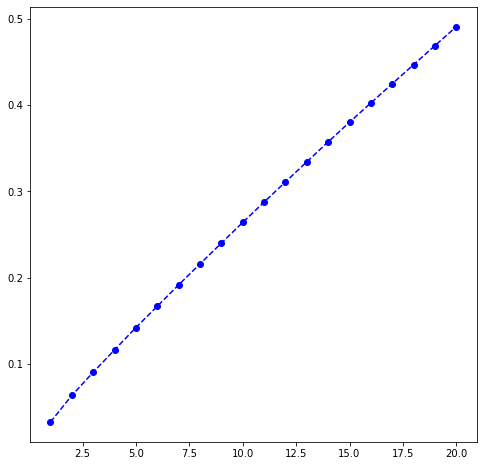

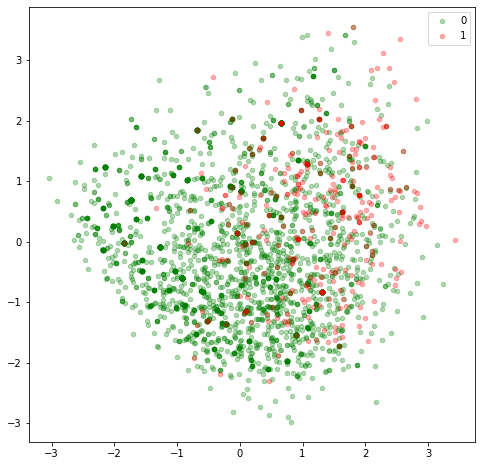

In [34]:
cols = [c for c in df_pt_dx.columns if 'diagnosis' in c]
df_pt_dx['implant']=linked_all3['implant']

dx_pca_df = pca_feature_reduction(df_pt_dx, cols, 'dx', 'implant', 20)
dx_pca_df.head()

### 3.7. Create a "dxcode" feature matrix

In [35]:
is_code=True
df_pt_dxcode, dxcode_vector_dict, dxcode_col_map= create_pt_vector(linked_all3, 'dxcode', 'tfidf', 10, is_code)
len(dxcode_vector_dict)
dxcode_vector_dict

37

{'k05.101': 6.805682464139582,
 's03.200': 6.805682464139582,
 'k04.701': 6.718671087149952,
 'k08.300': 6.564520407322694,
 'k00.100': 6.3703643928817355,
 'k04.802': 6.3703643928817355,
 'k08.100': 6.207845463383961,
 'k04.702': 6.159055299214529,
 'k07.400': 6.1125352835796365,
 'k08.103': 5.769590532452805,
 'k05.301': 5.648229675448539,
 'k00.208': 5.396915247167632,
 'z01.200': 5.291554731509806,
 'k04.001': 5.23328582338583,
 'k05.201': 5.09270387276464,
 'k04.902': 5.04469465357828,
 'k04.002': 4.969471232340693,
 'k04.401': 4.940897859896637,
 'k01.000': 4.809128582265513,
 'k02.400': 4.628866758434569,
 'k08.104': 4.476189918225611,
 'k08.302': 4.3360432864823695,
 'k05.204': 4.3283804137368005,
 'k00.001': 4.140982703910986,
 'k07.302': 4.091589948581409,
 'k00.002': 4.085583924521197,
 'k04.100': 4.06777929988769,
 'k05.600': 3.53715104882552,
 'k03.101': 3.5064842504325475,
 'k08.301': 3.3924367439612517,
 'k05.100': 2.994987710841323,
 'k04.500': 2.9555348624295226,
 'k07

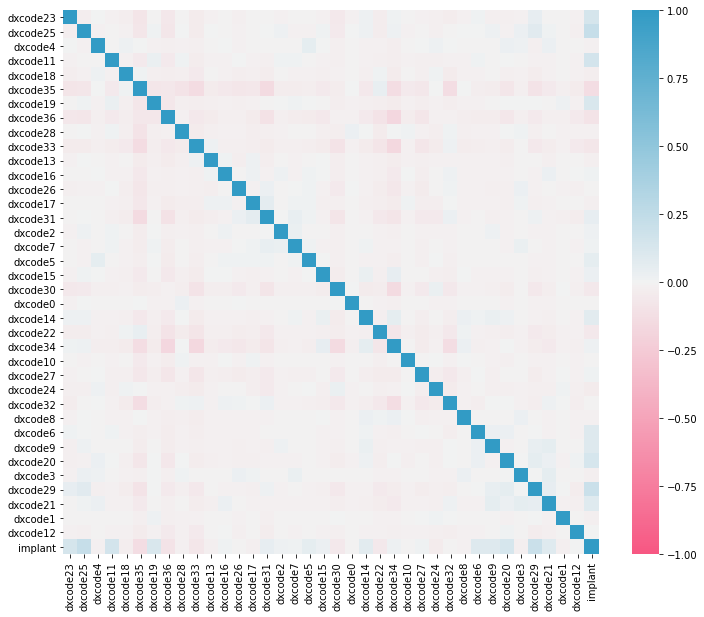

In [36]:
df_pt_dxcode['implant']=linked_all3['implant']
corr = df_pt_dxcode.corr()

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmax=1.0, vmin=-1.0, cmap=cmap)
plt.show();

In [37]:
corr['implant']

dxcode23    0.141785
dxcode25    0.224695
dxcode4    -0.011508
dxcode11    0.148689
dxcode18   -0.027791
dxcode35   -0.129915
dxcode19    0.120017
dxcode36   -0.093013
dxcode28   -0.008140
dxcode33   -0.072963
dxcode13   -0.019203
dxcode16    0.013603
dxcode26   -0.006120
dxcode17   -0.019570
dxcode31    0.052601
dxcode2     0.022329
dxcode7     0.008612
dxcode5     0.057210
dxcode15    0.027601
dxcode30   -0.061510
dxcode0    -0.003957
dxcode14    0.073655
dxcode22   -0.057541
dxcode34    0.016857
dxcode10   -0.005323
dxcode27    0.012943
dxcode24   -0.045584
dxcode32   -0.000152
dxcode8    -0.011961
dxcode6     0.097747
dxcode9     0.096245
dxcode20    0.137040
dxcode3    -0.018041
dxcode29    0.197978
dxcode21    0.088301
dxcode1    -0.015711
dxcode12    0.004883
implant     1.000000
Name: implant, dtype: float64

In [38]:
drop_dxcode = corr[corr['implant'].abs()<0.005].index
{d: dxcode_col_map[d] for d in drop_dxcode}
df_pt_dxcode.shape

{'dxcode0': 'k05.101', 'dxcode32': 'k07.303', 'dxcode12': 'z01.200'}

(3653, 38)

In [39]:
df_pt_dxcode.drop(drop_dxcode, axis=1, inplace=True)
df_pt_dxcode.shape

(3653, 35)

cumulative varation: 0.6371341232976707
Explained variation per principal component: [0.04259152 0.03844798 0.03428475 0.03399058 0.03276481 0.0323184
 0.03220596 0.03149918 0.03123009 0.03096488 0.0306712  0.03057122
 0.03026022 0.03001185 0.02978557 0.02947378 0.02938063 0.02907696
 0.02888061 0.02872392]


,dxcode_pca_0,dxcode_pca_1,dxcode_pca_2,dxcode_pca_3,dxcode_pca_4,dxcode_pca_5,dxcode_pca_6,dxcode_pca_7,dxcode_pca_8,dxcode_pca_9,...,dxcode_pca_11,dxcode_pca_12,dxcode_pca_13,dxcode_pca_14,dxcode_pca_15,dxcode_pca_16,dxcode_pca_17,dxcode_pca_18,dxcode_pca_19,implant
patient_uid,,,,,,,,,,,,,,,,,,,,,
1.01813e+17_33010619971115****,0.021351,0.046535,-0.143506,0.120542,-0.034924,-0.099477,0.070315,0.013471,0.042341,0.013771,...,0.065274,-0.019730,0.058563,-0.035833,0.029603,-0.060461,0.005874,-0.003832,-0.021304,0
1.01824e+17_33018419901128****,-1.549251,1.046219,-0.039795,0.956215,-0.545829,0.142719,-0.159996,0.321995,-0.373297,-0.048959,...,-0.319551,-0.012956,0.160063,0.552085,0.064228,-0.180896,0.108998,-0.186992,0.372036,0
1.02175e+17_33010219680103****,0.795555,-1.844938,-1.510900,0.721674,-0.610736,-0.034917,-0.017371,0.170153,-0.609704,-0.151701,...,0.548871,0.530888,-0.159216,-0.334532,-0.690545,0.315013,0.071717,-0.392099,-0.553718,0
1.02754e+17_33038119930913****,-0.974856,-0.812414,0.544959,-1.084545,0.435901,0.532835,-0.653348,-0.069785,-0.505132,-0.277580,...,-0.434885,-0.269397,0.406273,-0.215980,-0.566307,0.608995,-0.355817,0.336321,0.572367,0
1.02819e+17_32088119791212****,0.258515,0.819998,-0.107874,-1.198282,0.419043,0.661547,-0.584475,-0.057011,-0.218672,-0.037384,...,-0.454485,-0.178467,0.126484,0.225534,-0.335461,0.457862,-0.254389,-0.119006,0.727159,0


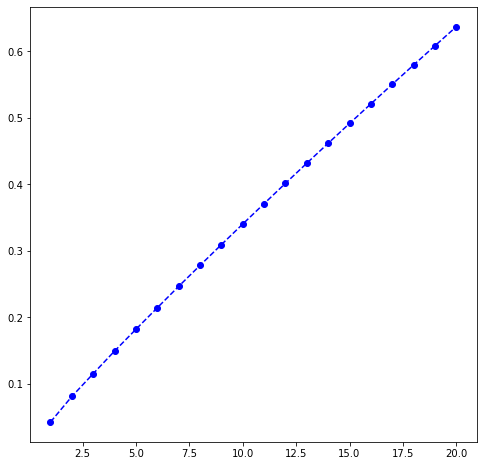

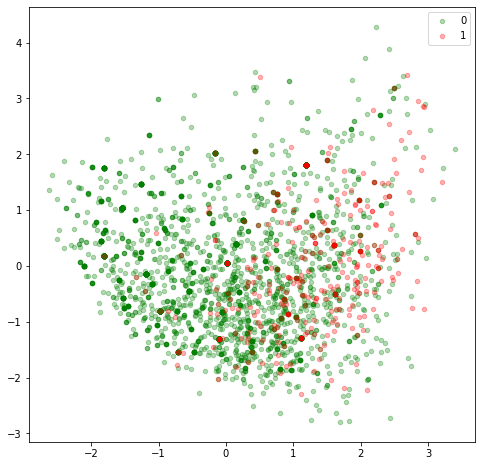

In [40]:
cols = [c for c in df_pt_dxcode.columns if 'dxcode' in c]
df_pt_dxcode['implant']=linked_all3['implant']

dxcode_pca_df = pca_feature_reduction(df_pt_dxcode, cols, 'dxcode', 'implant', 20)
dxcode_pca_df.head()

### 3.8. Create a "dept" feature matrix

In [41]:
df_pt_dept, cols_dept_dict, cnt_dept_feature_sorted= create_pt_categorical_feature_matrix(linked_all3, 'dept')
df_pt_dept

,dept7,dept8,dept1,dept3,dept4,dept0,dept6,dept2,dept9,dept5
1.01813e+17_33010619971115****,0,0,0,0,0,0,0,1,0,0
1.01824e+17_33018419901128****,0,0,0,0,0,1,0,0,0,0
1.02175e+17_33010219680103****,0,0,0,0,0,1,0,0,0,0
1.02754e+17_33038119930913****,0,0,0,0,0,0,0,1,0,1
1.02819e+17_32088119791212****,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
8.10964e+16_33032719550303****,0,0,0,1,1,0,0,0,0,0
8.11042e+16_33038219920724****,0,0,0,1,0,0,0,0,0,0
9.01935e+16_33012519741112****,0,0,0,0,0,0,1,0,0,1
9.3849e+16_32062119851123****,0,0,1,0,0,1,0,0,0,0


In [42]:
df_pt_dept, dept_vector_dict, dept_col_map = create_pt_vector(linked_all3, 'dept', 'tfidf', 1)
len(dept_vector_dict)
#df_pt_dx, dx_vector_dict, dx_col_map = create_pt_vector(linked_all3, 'diagnosis', 'tf', 20)

10

In [43]:
dept_vector_dict

{'财务室': 6.805682464139582,
 '名医馆六': 5.291554731509806,
 '名医馆五': 5.23328582338583,
 '牙体牙髓科': 3.554603498776746,
 '颌面外科': 2.9594108362742158,
 '洁牙美白中心': 2.81166062354535,
 '特需专家二': 2.6859064640256767,
 '特需专家一': 2.617406082083277,
 '牙周科': 2.5090156784168567,
 '名医馆': 2.034997839673917}

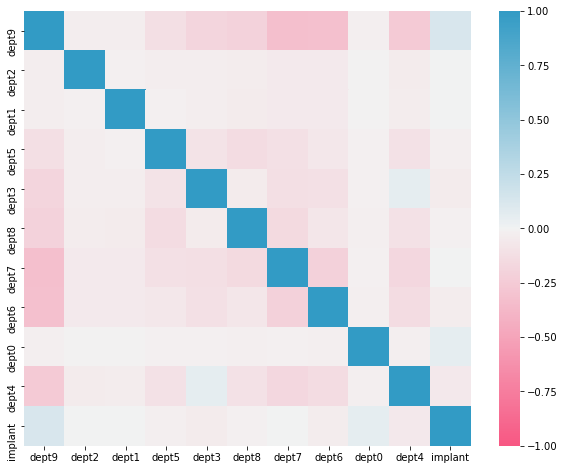

In [44]:
df_pt_dept['implant']=linked_all3['implant']
corr = df_pt_dept.corr()

plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmax=1.0, vmin=-1, cmap=cmap)
plt.show();

### 3.9. Create a px feature matrix

df_pt_px, cols_px_dict, cnt_px_feature_sorted= create_pt_categorical_feature_matrix(linked_all3, 'purchase', 20)
cnt_px_feature_sorted

In [45]:
df_pt_px, px_vector_dict, px_col_map= create_pt_vector(linked_all3, 'purchase', 'tf', 20)
len(px_vector_dict)

146

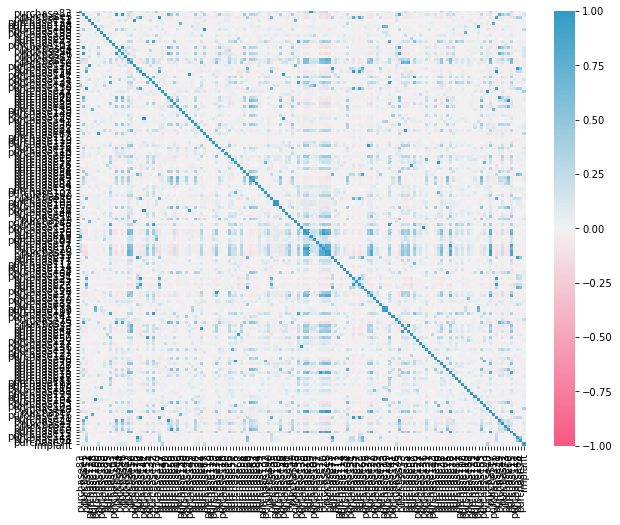

In [46]:
df_pt_px['implant']=linked_all3['implant']
corr = df_pt_px.corr()

plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmax=1.0, vmin=-1, cmap=cmap)
plt.show();

In [47]:
corr['implant']

purchase83     0.018888
purchase5      0.118152
purchase11     0.010494
purchase124    0.040093
purchase128    0.041805
                 ...   
purchase15    -0.033414
purchase111    0.055480
purchase68     0.013245
purchase74    -0.004237
implant        1.000000
Name: implant, Length: 147, dtype: float64

In [48]:
drop_px = corr[corr['implant'].abs()<0.005].index
{d: px_col_map[d] for d in drop_px}
df_pt_px.drop(drop_px, axis=1, inplace=True)

{'purchase100': '仅和',
 'purchase133': '充填',
 'purchase142': '包括钙化桥',
 'purchase143': '塑化根管再通',
 'purchase105': '无痛局麻仪一次性材料',
 'purchase106': '无痛局麻仪注射',
 'purchase144': '显微根管再治疗术',
 'purchase40': '普通树脂充填',
 'purchase145': '材料',
 'purchase135': '树脂贴面',
 'purchase27': '纳米树脂充填',
 'purchase136': '纳米树脂前牙美容修复',
 'purchase31': '自费时用',
 'purchase74': '龈下超声洁治'}

cumulative varation: 0.7370611749613716
Explained variation per principal component: [0.11162785 0.07687002 0.0538894  0.03336006 0.0297447  0.02655212
 0.02491776 0.02251269 0.02044164 0.01903447 0.01889939 0.01725765
 0.01576945 0.0151711  0.01484393 0.01370614 0.01265906 0.01225014
 0.01206674 0.01150414 0.0110008  0.01050381 0.01021778 0.01001165
 0.00950488 0.00922678 0.00898529 0.00884041 0.00868918 0.00858223
 0.00839261 0.00820732 0.00810689 0.0079621  0.00782246 0.0077422
 0.0076228  0.00758609 0.00754016 0.0074373 ]


,px_pca_0,px_pca_1,px_pca_2,px_pca_3,px_pca_4,px_pca_5,px_pca_6,px_pca_7,px_pca_8,px_pca_9,...,px_pca_31,px_pca_32,px_pca_33,px_pca_34,px_pca_35,px_pca_36,px_pca_37,px_pca_38,px_pca_39,implant
patient_uid,,,,,,,,,,,,,,,,,,,,,
1.01813e+17_33010619971115****,-1.927480,-2.308299,-2.557495,0.296761,0.544963,0.317975,1.055536,-0.513715,-0.694915,0.765122,...,0.128815,-0.638862,0.183611,-0.639016,-0.147092,0.110588,-0.126279,0.082064,-0.275581,0
1.01824e+17_33018419901128****,-1.825345,-1.036413,-1.990357,0.711769,-0.777670,0.261103,-0.887086,-0.734350,-0.035582,-0.541846,...,0.426468,-0.399219,0.257884,-0.083510,-0.135832,-0.222259,-0.649603,-0.179996,0.374545,0
1.02175e+17_33010219680103****,5.669469,-0.817707,-1.100311,-3.882433,-0.340547,-0.170603,-1.208431,-0.434621,0.384501,1.495145,...,-0.089817,-0.036256,-0.150465,0.444454,0.585647,0.080654,-0.407218,0.538272,-0.439651,0
1.02754e+17_33038119930913****,-2.046308,-2.050666,-2.312845,0.513230,0.687750,0.596974,0.204698,1.545761,0.033454,-0.126226,...,-0.425667,-0.334697,1.008946,1.182262,0.024453,0.681853,0.574169,-0.108539,0.349722,0
1.02819e+17_32088119791212****,-2.830479,-3.489645,1.664543,-0.185221,1.266152,-2.387739,0.487089,-0.247928,-0.119641,-0.201424,...,0.295299,-0.082502,0.070948,0.068352,0.162842,-0.203277,-0.215658,0.085452,-0.129119,0


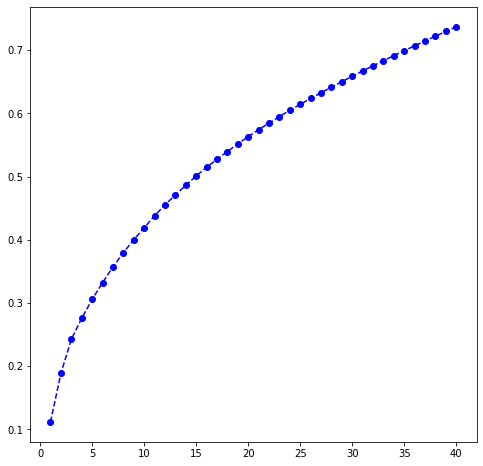

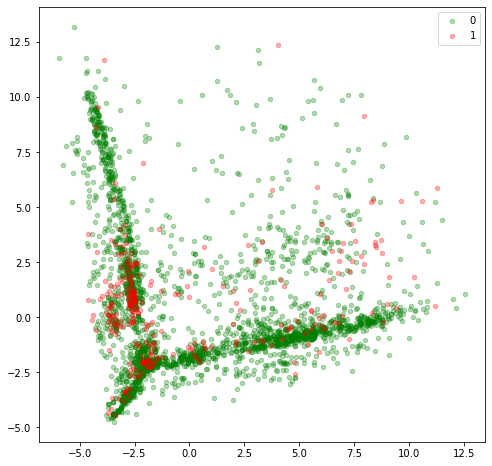

In [49]:
cols = [c for c in df_pt_px.columns if 'purchase' in c]
df_pt_px['implant']=linked_all3['implant']

px_pca_df = pca_feature_reduction(df_pt_px, cols, 'px', 'implant', 40)
px_pca_df.head()

,px_tsne_0,px_tsne_1
patient_uid,,
1.01813e+17_33010619971115****,-19.984003,-4.721117
1.01824e+17_33018419901128****,-51.768867,-3.008936
1.02175e+17_33010219680103****,11.346096,-29.956257
1.02754e+17_33038119930913****,-36.433411,45.306217
1.02819e+17_32088119791212****,62.410568,5.283770


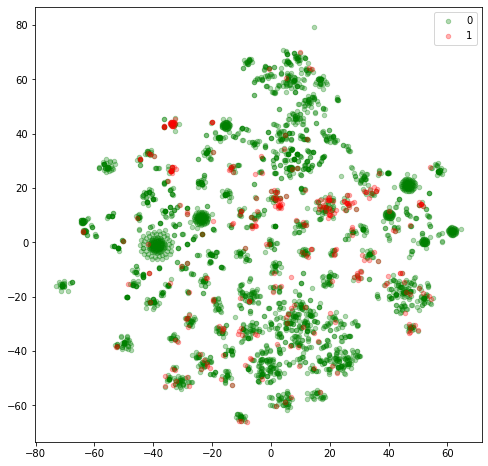

In [50]:
def tsne_marker(df, cols, alias, label_col, n=2):
    
    x = df.loc[:, cols].values
    x = StandardScaler().fit_transform(x)
    
    y = df.loc[:, label_col].values
   

    #pca = PCA(n_components=m)
    tsne = TSNE(n_components=n)#, perplexity=20, n_iter=1000, learning_rate=200)
    #tsne_after_pca = Pipeline([('pca', pca), ('tsne', tsne)])
    dr = tsne.fit_transform(x)
   
    tsne_cols = [alias+'_tsne_'+str(k) for k in range(n)]
    tsne_df = pd.DataFrame(data=dr, columns=tsne_cols, index=df.index)
    final_tsne_df=pd.concat([tsne_df, df[[label_col]]], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    targets = [0, 1]
    colors = ['g', 'r']
    for target, color in zip(targets, colors):
        indicesToKeep = final_tsne_df[label_col] == target
        ax.scatter(final_tsne_df.loc[indicesToKeep, alias+'_tsne_0'], final_tsne_df.loc[indicesToKeep, alias+'_tsne_1'], c=color, s=20, alpha=0.3);
    ax.legend(targets);
    
    return tsne_df

cols = [c for c in df_pt_px.columns if 'purchase' in c]
px_tsne_df = tsne_marker(df_pt_px, cols, 'px', 'implant', 2)
px_tsne_df.head()
#x_train = tsne_marker(train_x, l, n_pca, n_tsne)

### 3.10 Create final feature matrix

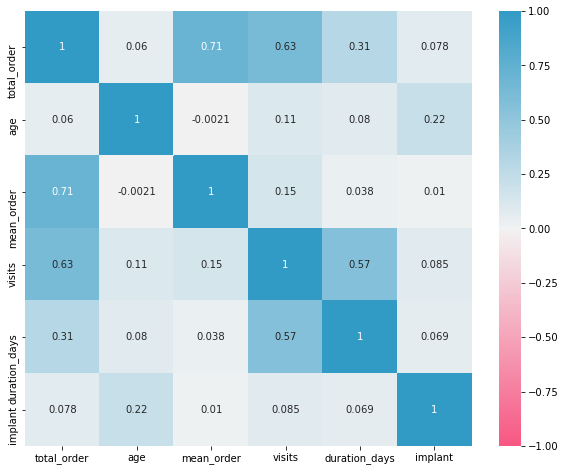

In [51]:

corr = linked_all3[['total_order', 'age', 'mean_order', 'visits', 'duration_days', 'implant']].corr()

plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmax=1.0, vmin=-1, cmap=cmap, annot=True)
plt.show();

In [52]:
print(df_pt_dx.shape, px_pca_df.shape, df_pt_dept.shape, dxcode_pca_df.shape)

(3653, 46) (3653, 41) (3653, 11) (3653, 21)


In [53]:
linked_df = pd.concat([linked_all3, 
                       df_pt_dx.drop(['implant'], axis=1), 
                       df_pt_dept.drop(['implant'], axis=1), 
                       px_pca_df.drop(['implant'], axis=1), 
                       dxcode_pca_df.drop(['implant'], axis=1)], axis=1)

linked_df.drop(['diagnosis', 'treatment_plan', 'purchase', 'order_type', 'date_list', 'mean_order', 'dept', 'dxcode'], axis=1, inplace=True)
linked_df.shape

(3653, 122)

In [54]:
linked_df.head()

,total_order,gender,age,duration_days,visits,visit_interval,implant,diagnosis30,diagnosis2,diagnosis11,...,dxcode_pca_10,dxcode_pca_11,dxcode_pca_12,dxcode_pca_13,dxcode_pca_14,dxcode_pca_15,dxcode_pca_16,dxcode_pca_17,dxcode_pca_18,dxcode_pca_19
patient_uid,,,,,,,,,,,,,,,,,,,,,
1.01813e+17_33010619971115****,8.00,0,21,0,1,0.000000,0,0.000000,0.0,0.0,...,0.077847,0.065274,-0.019730,0.058563,-0.035833,0.029603,-0.060461,0.005874,-0.003832,-0.021304
1.01824e+17_33018419901128****,142.98,1,28,0,1,0.000000,0,0.000000,0.0,0.0,...,-0.014838,-0.319551,-0.012956,0.160063,0.552085,0.064228,-0.180896,0.108998,-0.186992,0.372036
1.02175e+17_33010219680103****,1203.82,0,51,112,4,28.000000,0,0.000000,0.0,0.0,...,-0.531396,0.548871,0.530888,-0.159216,-0.334532,-0.690545,0.315013,0.071717,-0.392099,-0.553718
1.02754e+17_33038119930913****,8360.00,0,25,46,3,15.333333,0,0.814984,0.0,0.0,...,0.199924,-0.434885,-0.269397,0.406273,-0.215980,-0.566307,0.608995,-0.355817,0.336321,0.572367
1.02819e+17_32088119791212****,211.00,1,39,0,1,0.000000,0,0.000000,0.0,0.0,...,0.186054,-0.454485,-0.178467,0.126484,0.225534,-0.335461,0.457862,-0.254389,-0.119006,0.727159


## 4. Train Model
### 4.1. Train-test data split

(3653, 121) (3653,)


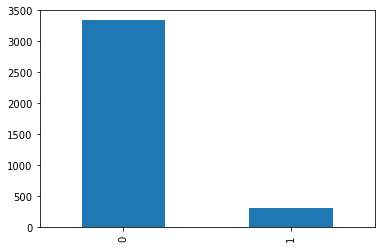

In [55]:
X0 = linked_df.drop(axis = 1, columns = ['implant']).values
Y0 = linked_df['implant'].values
print(X0.shape, Y0.shape)
pd.Series(Y0).value_counts().plot.bar();

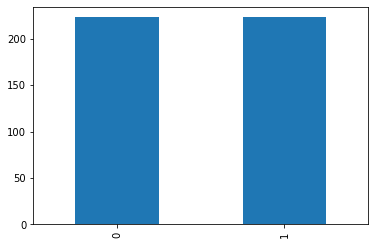

In [56]:
def sampling(train_x0, train_y0, sampling):
    
    if sampling == 'under':
        nm = NearMiss(version=3)
        train_x, train_y = nm.fit_resample(train_x0, train_y0)
    elif sampling =='over':
        oversample = BorderlineSMOTE(random_state=10, kind="borderline-2")
        train_x, train_y = oversample.fit_resample(train_x0, train_y0.ravel())
    pd.Series(train_y).value_counts().plot.bar();
    
    return train_x, train_y

train_x0, test_x0, train_y0, test_y0 = train_test_split(X0, Y0, test_size = 0.3, random_state = 1)

train_x, train_y = sampling(train_x0, train_y0, 'under')
train_x = StandardScaler().fit_transform(train_x)

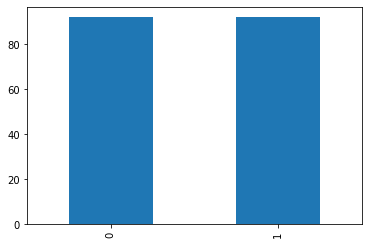

In [57]:
test_x, test_y = sampling(test_x0, test_y0, 'under')
test_x = StandardScaler().fit_transform(test_x)

## Helper Fuctions: plot_lift_curve, plot_learning_curve

In [148]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    '''
    y_val: label of test data 
    y_pred: probability of prediction ons for such data
    step: resolution
    '''    
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    # sorted by the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    x_val = np.arange(step, 1+step, step)
    # Ratio of positive label
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    
    y_v = []
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) # the # of data points based on ratio x 
        data_here = aux_lift.iloc[:num_data,:]  # a subset of sorted data
        ratio_ones_here = data_here['real'].sum()/len(data_here) # ratio of positive labels within this subset
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    axis.plot(x_val, y_v, 'r-');
    axis.plot(x_val, np.ones(len(x_val)), 'g-');
    axis.set_xlabel('Proportion of sample');
    axis.set_ylabel('Lift');
    plt.show();

    return

def plot_learning_curve(model, train_x, train_y, test_x, test_y, n_splits=10):
    '''
    train_x, train_y: training data and training label
    test_x, test_y: training data and training label
    '''    
    X = np.concatenate((train_x, test_x), axis=0)
    Y = np.concatenate((test_y, train_y), axis=0)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state=7) 
    
    LC = learning_curve(estimator=model, X=X, y=Y, cv=kfold, train_sizes=np.linspace(0.10, 1.00, 20))

    #plt.figure(figsize =(12, 10))
    plt.plot(LC[0],np.nanmean(LC[1], axis=1),c='blue');
    plt.plot(LC[0],np.nanmean(LC[2], axis=1), c='green');
    plt.show();

    return



### 4.2. Baseline model:

In [58]:
rfc = RandomForestClassifier(oob_score = True).fit(train_x, train_y)
prob_rfc = rfc.predict_proba(test_x)
class_rfc = rfc.predict(test_x)

print(classification_report(test_y, class_rfc))
print('AUC: ', roc_auc_score(test_y, prob_rfc[:,1]))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        92
           1       0.81      0.79      0.80        92

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

AUC:  0.8865193761814745


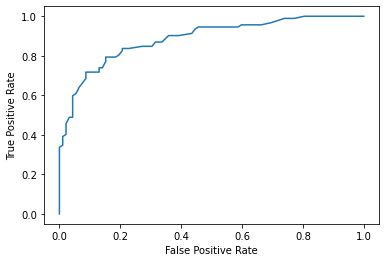

In [59]:
y_score = prob_rfc[:, 1]

fpr, tpr, _ = roc_curve(test_y, y_score, pos_label=rfc.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

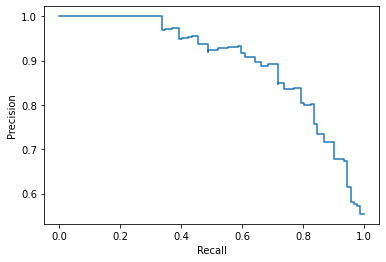

In [60]:
prec, recall, _ = precision_recall_curve(test_y, y_score, pos_label=rfc.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

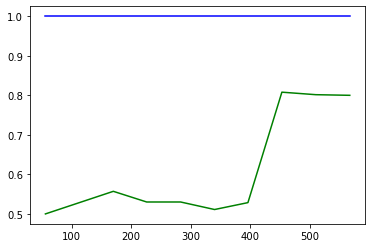

In [61]:
from sklearn.model_selection import learning_curve

X1 = np.concatenate((train_x, test_x), axis=0)
Y1 = np.concatenate((test_y, train_y), axis=0)

kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7) 

LC = learning_curve(estimator=rfc, X=X1, y=Y1, cv=kfold, train_sizes=np.linspace(0.10, 1.00, 10))

#plt.figure(figsize =(12, 10))
plt.plot(LC[0],np.nanmean(LC[1], axis=1), c='blue');
plt.plot(LC[0],np.nanmean(LC[2], axis=1), c='green');
plt.show();

### 4.3. Recursivce Feature Elimination (RFECV) in feature selecting to avoid over-fitting

The optimal number of features: 16


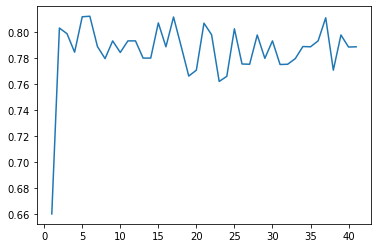

In [62]:
rfecv = RFECV(estimator=rfc, step=3, cv=StratifiedKFold(10), scoring='recall')
rfecv.fit(train_x, train_y)

print('The optimal number of features: {}'.format(rfecv.n_features_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_,)
plt.show();

In [63]:
feature_list = linked_df.drop(axis = 1, columns = ['implant']).columns
col_idx = {i: v for i, v in enumerate(feature_list)}

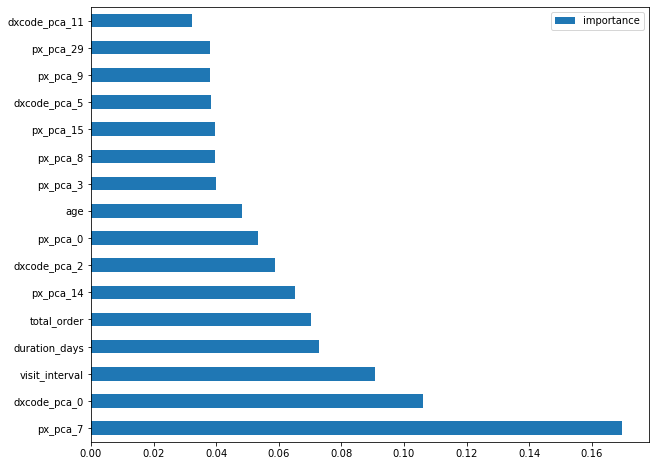

In [64]:
feature_list = linked_df.drop(axis = 1, columns = ['implant']).columns

selected_feature_list=[feature_list[i] for i, v in enumerate(rfecv.support_ ) if v == True]

selected_features = dict(zip(selected_feature_list, rfecv.estimator_.feature_importances_))

df_selected_features = pd.DataFrame().from_dict(selected_features, orient='index', columns=['importance']).sort_values(by=['importance'], ascending=False)
df_selected_features.head(10)

df_selected_features.plot.barh(figsize=(10, 8));

In [65]:
len(selected_feature_list)

16

### 4.4. Re-train model with selected featuers

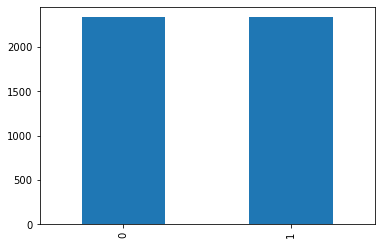

In [135]:
def sampling(train_x0, train_y0, sampling):
    
    if sampling == 'under':
        nm = NearMiss(version=3)
        train_x, train_y = nm.fit_resample(train_x0, train_y0)
    elif sampling =='over':
        oversample = BorderlineSMOTE(random_state=10, kind="borderline-2")
        train_x, train_y = oversample.fit_resample(train_x0, train_y0.ravel())
    pd.Series(train_y).value_counts().plot.bar();
    
    return train_x, train_y

X1 = linked_df.drop(axis = 1, columns = ['implant'])[selected_feature_list].values
Y1 = linked_df['implant'].values

train_x0, test_x0, train_y0, test_y0 = train_test_split(X1, Y1, test_size = 0.3, random_state = 1)

train_x, train_y = sampling(train_x0, train_y0, 'over')
train_x = StandardScaler().fit_transform(train_x)

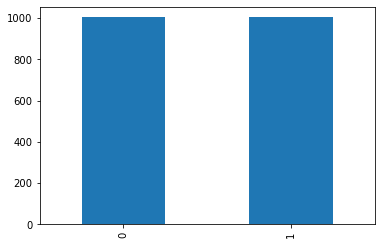

In [136]:
test_x, test_y = sampling(test_x0, test_y0, 'over')
test_x = StandardScaler().fit_transform(test_x)

In [137]:
rfc2 = RandomForestClassifier(oob_score = True).fit(train_x, train_y)
prob_out = rfc.predict_proba(test_x)
class_out = rfc.predict(test_x)

print(classification_report(test_y, class_out))
print('AUC: ', roc_auc_score(test_y, prob_out[:,1]))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1004
           1       0.91      0.72      0.80      1004

    accuracy                           0.82      2008
   macro avg       0.84      0.82      0.82      2008
weighted avg       0.84      0.82      0.82      2008

AUC:  0.9023775416263233


[0 1]


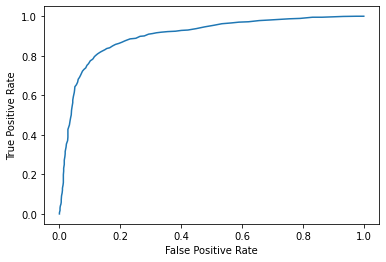

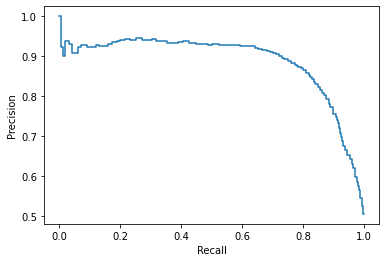

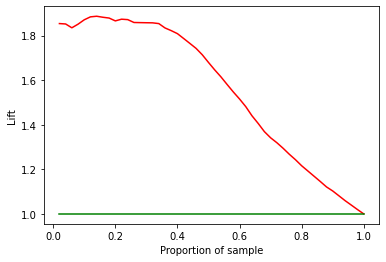

In [138]:
# get probablity output of the positive 
print(rfc.classes_)
y_score = prob_out[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(test_y, y_score, pos_label=rfc.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# precision-recall curve
prec, recall, _ = precision_recall_curve(test_y, y_score, pos_label=rfc.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# lift-curve
plot_lift_curve(test_y, y_score, 0.02)

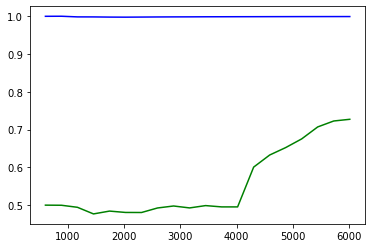

In [133]:
# learning curve
plot_learning_curve(rfc2, train_x, train_y, test_x, test_y, 5)

In [139]:
print(rfc2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [149]:
max_depth = np.arange(10, 100, 10)
min_samples_leaf = np.arange(1, 4, 2)
bootstrap=[True, False]

param_grid = dict(min_samples_leaf=min_samples_leaf, max_depth=max_depth, bootstrap=bootstrap)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(rfc2 ,param_grid=param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = gridsearch.fit(train_x, train_y) 
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

Best: 0.950724 using {'max_depth': 9, 'min_samples_leaf': 2}


In [150]:
print("Best: %f using %s" % (grid_result.best_score_, gridsearch.best_params_))

best_grid = gridsearch.best_estimator_

prob_out = best_grid.predict_proba(test_x)
class_out = best_grid.predict(test_x)

print(classification_report(test_y, class_out))
print('AUC: ', roc_auc_score(test_y, prob_out[:,1]))


Best: 0.950724 using {'max_depth': 9, 'min_samples_leaf': 2}
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1004
           1       0.88      0.79      0.83      1004

    accuracy                           0.84      2008
   macro avg       0.85      0.84      0.84      2008
weighted avg       0.85      0.84      0.84      2008

AUC:  0.9064121998063523


[0 1]


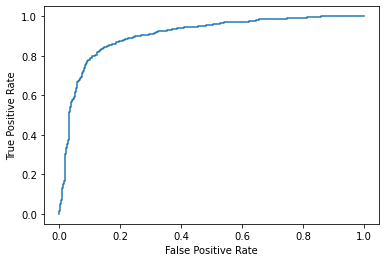

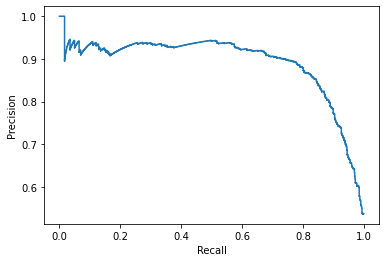

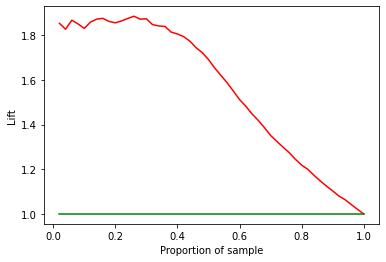

In [152]:
# get probablity output of the positive 
#print(rfc.classes_)
y_score = prob_out[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(test_y, y_score, pos_label=rfc.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# precision-recall curve
prec, recall, _ = precision_recall_curve(test_y, y_score, pos_label=rfc.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# lift-curve
plot_lift_curve(test_y, y_score, 0.02)

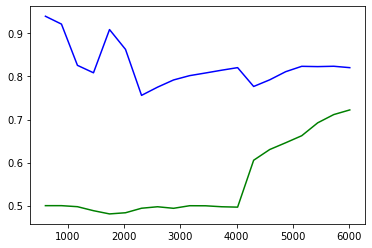

In [153]:
# learning curve
plot_learning_curve(best_grid, train_x, train_y, test_x, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1004
           1       0.87      0.75      0.80      1004

    accuracy                           0.82      2008
   macro avg       0.82      0.82      0.82      2008
weighted avg       0.82      0.82      0.82      2008



0.9010898636529578

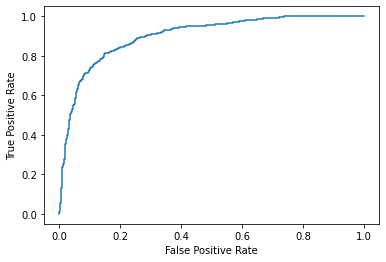

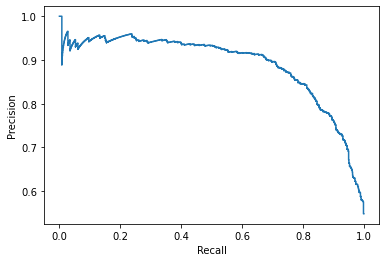

In [154]:
from xgboost import XGBClassifier
from xgboost import plot_importance

XGB = XGBClassifier(objective = "binary:logistic", tree_method='auto')
XGB.fit(train_x, train_y, eval_set = [(test_x, test_y)], verbose = 0)

prob_out = XGB.predict_proba(test_x)
class_out = XGB.predict(test_x)

print(classification_report(test_y, class_out))
roc_auc_score(test_y, prob_out[:,1])

y_score = prob_out[:, 1]
# ROC curve
fpr, tpr, _ = roc_curve(test_y, y_score, pos_label=XGB.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# precision-recall curve
prec, recall, _ = precision_recall_curve(test_y, y_score, pos_label=XGB.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

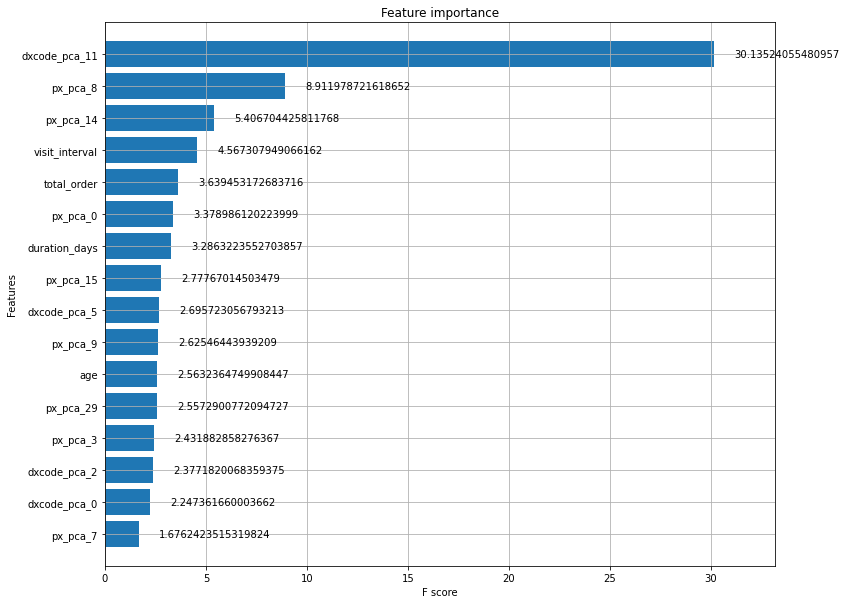

In [155]:
def f_importance_plot(model, metric = "gain"):

    fig,ax = plt.subplots(figsize=(12, 10))
    plot_importance(model, height=0.8, ax=ax, max_num_features=100, importance_type = metric)

    id_l = [int(re.findall(r"\d+",str(i))[2]) for i in plt.yticks()[1]]
    id_l.reverse()
    f_name = [selected_feature_list[i] for i in id_l]
    plt.yticks(range(len(f_name)),f_name,fontsize = 10)
    
    plt.show()

f_importance_plot(XGB, metric ='gain')